# From DDPM to Flow Matching

Ever wondered how to turn your existing _denoising diffusion code_ into a _flow matching_ approach? 🤔 Or what all the fuss regarding diffusion models was about in the first place? 🧐 That's exactly what this notebook is focusing on 😎

We'll be using a learning task where we can reliably generate arbitrary amounts of ground truth data, to make sure we can quantify how well the target distribution was learned. Specifically, we'll focus on Reynolds-averaged Navier-Stokes simulations around airfoils, which have the interesting characteristic that typical solvers (such as OpenFoam) transition from steady solutions to oscillating ones for larger Reynolds numbers. This transition is exactly what we'll give as a task to diffusion models below. (Details can be found in our [diffuion-based flow prediction repository](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/).)

## Intro

Diffusion models have been rising stars in the deep learning field in the past years, and have made it possible to train powerful generative models with surprisingly simple and robust training setups. Within this sub-field of deep learning, a very promising new development are flow-based approaches, typically going under names such as _flow matching_ {cite}`lipman2022flow` and _rectified flows_ {cite}`liu2022rect` . We'll stick to the former here for simplicity, and denote this class of models with _FM_.

For the original diffusion models, especially the _denoising_ tasks were extremely successful: a neural network learns to restore a signal from pure noise. Score functions provided an alternate viewpoint, but ultimately also resulted in denoising tasks. Instead, flow-based approaches aim for transforming distributions. The goal is to transform a known one, such as gaussian noise, into one that represents the distribution of the signal or target function we're interested in. Despite these seemingly different viewpoints, all viewpoints above effectively do the same: starting with noise, they step by step turn it into samples for our target signal. Interestingly, the FM-perspective is not only more stable at training time, it also speeds up inference by orders of magnitude thanks to yielding straighter paths. And even better: if you have a working DM setup, it's surprisingly simple to turn it into an FM one.

Below, we'll highlight the simiarities and differences, and evaluate both methods with the RANS-based flow setup outlined above.


## Problem statement

Instead of the previous supervised learning tasks, we'll need to consider distributions. For "classic" supervised tasks, we have unique input-output pairs $(x,y)$ and train a model to provide $y$ given $x$ based on internal parameters $\theta$, i.e. $y=f(x;\theta)$.

In contrast, let's assume there is _some_ hidden state $\psi$, that varies for a single $x$. This could e.g. be measurement noise, the starting point of an optimization for inverse problems, or the non-converging solution of a RANS solver (our scenario here). Now we can phrase our problem in terms of random variable $Y$, and our solution is drawn from the distribution $y \sim P_Y(Y)$ that we typically specify as a marginalized distribution, in terms of samples with varying $\psi$ for any given $x$. From a probabilistic perspective, it is important to capture the conditional probabilty of our solutions, i.e. $p(y|x)$, where we marginalize over $\psi$. (We don't need to know about the specifics of $\psi$ in practice.)

This conditional distribution $p(y|x)$, the _posterior_, is exactly what our generative model should learn: when we repeatedly evaluate our model, it should give us samples from the posterior with the right probabilities. And it should do so efficiently, without wasting computations...



## Implementation and Setup

First, we need to install the required packages and clone the repository:


In [1]:
try:
    import google.colab  # to ensure that we are inside colab
    !pip install --upgrade --quiet einops bayesian_torch
except ImportError:
    print('This notebook is running locally, please make sure the necessary pip packages are installed.')
    pass
!git clone https://github.com/tum-pbs/Diffusion-based-Flow-Prediction.git
%cd Diffusion-based-Flow-Prediction/

/home/thuerey/jupyter/Diffusion-based-Flow-Prediction


/home/thuerey/anaconda3/envs/torch24/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


We also need to prepare the training dataset. The one below can be generated with [OpenFoam](https://www.openfoam.com/
), but is downloaded below for convenience. The data structure and the `DataFiles` class that are used to organize the dataset come from the diffusion-based flow prediction repository, details can be found [here](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/generate_dataset.ipynb) if you're interested.


In [2]:
import zipfile
from airfoil_diffusion.airfoil_datasets import *
from airfoil_diffusion.networks import *
from airfoil_diffusion.trainer import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: "+str(device))

if not os.path.exists("./datasets/1_parameter/data/"):
    files=[file for file in os.listdir("./datasets/1_parameter/") if file.endswith(".zip")]
    for file in tqdm(files):
        f=zipfile.ZipFile("./datasets/1_parameter/"+file,'r')
        for file in f.namelist():
            f.extract(file,"./datasets/1_parameter/data/")
        f.close()

df_train=FileDataFiles("./datasets/1_parameter/train_cases.txt",base_path="./datasets/1_parameter/data/")
train_dataset = AirfoilDataset(df_train,data_size=32)

Using device: cuda:0


Loading data: 100%|██████████| 125/125 [00:00<00:00, 341.19it/s]


Next, we'll implement the denoising diffusion model, so that we can compare with flow matching afterwards.

------------------------


## Denoising with Diffusion Models

At it's core, the denoising task is as simple as the name implies: we learn to estimate the noise $\epsilon$ by minimizing
$
    \parallel \epsilon - f_\theta(x,t) \parallel^2
$,
the trick is primarily to carefully control the noise so that it can be learned easily.

Note that for all equations here, we'll omit the $i$ subscript that previously denoted the different samples of a batch or dataset in {doc}`overview-equations`. Thus, we'll e.g. shorten $y_{i}$ to $y$, and leave out summations over $i$.

To get started with denoising, we'll define a forward process that
adds noise to give a perfect
Gaussian distribution $\mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ at $t=1$.
It starts with a data sample $y$ at $t=0$, i.e. $\mathcal{N}\left(y, 0\right)$ and then turns it into noise as $t$ increases. Note that the noising / denoising time $t$ is a _virtual_ one, it has no physical meaning.
The change of mean and standard deviation over time $t$ is controlled by a
 _noise schedule_  $\beta^t \in (0,1)$, that gradually increases from $0$ to $\beta^t=1$ at the end of the chain, where $t=1$.

By choosing a Gaussian distribution, we can decouple the steps to give a Markov chain for the distribution $q$ of the form 

$$
    q\left(y^{0:T}\right) =
    q(y^0) \prod_{t=1}^{T}  q\left(y^{t} \mid y^{t-1}\right) ,
$$

where

$$
    q\left(y^{t} \mid y^{t-1}\right) = \mathcal{N}
    \left( \sqrt{1-\beta^{t}} y^{t-1}, \beta^{t} \mathbf{I}\right) .
$$

It's fairly obvious that we can destroy any input signal $y$ by accumulating more and more noise. What's more interesting is
the reverse process that removes the noise, i.e. the denoising. We can likewise formulate a
reverse Markov chain for the distribution $p_\theta$. The subscript already indicates that we'll learn the transition and parameterize it by a set or parameters $\theta$:

$$
    p_\theta\left(y^{0:T}\right)
    =
    p(y^T)
    \prod_{t=1}^{T}
    p_\theta \left(y^{t-1} \mid y^{t}\right)
$$

with

$$
    y^{t} = \sqrt{\bar{\alpha}^t} y^{0}
    +\sqrt{\left(1-\bar{\alpha}^t\right)}\epsilon .
$$ (eq-yt)

We can calculate the correct coefficients $\alpha$ from the noise schedule of the forward chain via
$\alpha^t = 1 - \beta^t$ and $\bar{\alpha}^t = \prod_{i=1}^t \alpha^i$.

Each step $p_\theta \left(y^{t-1} \mid y^{t}\right)$ along the way now has the specific form

$$
    p_\theta \left(y^{t-1} \mid y^{t}\right) =
    \mathcal{N} \left( \mu(f_{\theta}) , \sigma_{\theta} \right)
$$ (eq-denoising-step)  

where we're employing a neural network $f_\theta$ to predict the noise. We could also call the network $\epsilon_\theta$ here, but for consistency we'll stick to $f_\theta$. The noise inferred by our network parametrizes the mean

$$
    \mu(\epsilon) =
    \frac{1}{\sqrt{\alpha^t}}
    \Big(
        y^t - \frac{\beta^t}{\sqrt{1 - \bar{\alpha}^t}} \epsilon
    \Big) .
$$

The standard deviation interestingly does not depend on the noise (and our network), but evolves over time with

$$
    \sigma=
    \frac{1-\bar{\alpha}^{t-1}}
    {1-\bar{\alpha}^{t}}\beta^{t} \mathbf{I}.
$$

Thus, given a pair $x,y$, we can directly compute the right amount of noise for time $t-1$ and $t$, and generate $y^t$ and $y^{t-1}$. In practice, we're not only interested in retrieving an arbitrary $y$, but the one that corresponds to some global paramters like a chosen Reynolds number. These conditions, together with e.g. the shape of an airfoil are actually our $x$ from $f(x)=y$ at the top.
So, we'll also condition $f$ on $x$ to have the form $f_\theta (y^t,x,t)$.

In practice, we simply choose a time $t$, compute the right amount of noise $\epsilon$, and let our network predict the noise given $y^t$ computed by linear interpolation with $\bar{\alpha}^t$, as given above in equation `ref`(eq-yt).
This gives the loss function:
$$
    \mathcal{L}_{\text{DM}}(\theta) = \mathbb{E}_{x,\epsilon \sim\mathcal{N}(\mathbf{0},\mathbf{I}),t  }
    \left[   \parallel \epsilon - f_\theta(y^t,x,t) \parallel^2   \right]
$$


## Implementing DDPM

We'll split the implementation into a helper class that computes the coefficients for the denoising schedule, and a trainer class that takes care of the training loop.

The helper class is callsed `MyDiffuser` below, and starts by computing the beta coefficients for a so called _cosine-beta_ schedule.
It has the form $\beta = cos\big( (t/T+s)~/~(1+s) * \pi/2 \big)^2$.
The offset $s$ below is chosen such that the standard deviation of the $\sqrt{\beta}$ is smaller than the color step of $1/256$ for a typical RGB image. The `generate_parameters_from_beta()` function takes the precomputed list of `beta` coefficients, and turns them into PyTorch tensors, computing the correct `alpha` and `alpha_bar` values along the way.

The class also implements a function `forward_diffusion()` that calculates forward diffusion step using the precomputed `alpha_bar` values, given an input $y$ and $t$. Hence, this function computes $y^t$ from above.



In [3]:
class MyDiffuser():
    def __init__(self, steps, device):
        self.device = device
        self.steps = steps
        self.name = "Cos2ParamsDiffuser"

        s = 0.008
        tlist = torch.arange(1, self.steps+1, 1)
        temp1 = torch.cos((tlist/self.steps+s)/(1+s)*np.pi/2)
        temp1 = temp1*temp1
        temp2 = np.cos(((tlist-1)/self.steps+s)/(1+s)*np.pi/2)
        temp2 = temp2*temp2
        self.beta_source = 1-(temp1/temp2)
        self.beta_source[self.beta_source > 0.999] = 0.999
        self.generate_parameters_from_beta()


    def generate_parameters_from_beta(self):
        self.betas = torch.cat( (torch.tensor([0]), self.beta_source), dim=0)
        self.betas = self.betas.view(self.steps+1, 1, 1, 1)
        self.betas = self.betas.to(self.device)

        self.alphas = 1-self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        self.one_minus_alphas_bar = 1 - self.alphas_bar
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(self.one_minus_alphas_bar)


    def forward_diffusion(self, y0, t, noise):
        yt = self.sqrt_alphas_bar[t]*y0+self.sqrt_one_minus_alphas_bar[t]*noise
        return yt


Now we're ready to start training. The `MyDiffusionTrainer` class derives from a `Trainer` base class from the airfoil diffusion repository. This base class primarily handles parameters, book-keeping and a few other mundane tasks. Effectively, it makes sure we have a batch to train with, and then calls `train_step()`, which is the most interesting function below.

It implements exactly the procedure outlines above: given a $y$, we compute noise, and $y^t$ with a forward step for a random $t$. Then we let our network predict the noise $\epsilon$ from $y^t$, the condition $x$, and $t$. All that's left afterwards is to compute an MSE loss on the true noise versus the precicted one, and let PyTorch backpropagate the gradient to update the weights of our neural network.

In [4]:
class MyDiffusionTrainer(TrainerStepLr):

    def __init__(self) -> None:
        super().__init__()

    def set_configs_type(self):
        super().set_configs_type()
        self.configs_handler.add_config_item("diffusion_step",value_type=int,default_value=200,description="The number of diffusion steps.")

    def event_before_training(self,network):
        self.diffuser = MyDiffuser(steps=self.configs.diffusion_step,device=self.configs.device)

    def train_step(self, network: torch.nn.Module, batched_data, idx_batch: int, num_batches: int, idx_epoch: int, num_epoch: int):
        condition = batched_data[0].to(device=self.configs.device)
        targets = batched_data[1].to(device=self.configs.device)
        t = torch.randint(1, self.diffuser.steps+1,
                          size=(targets.shape[0],), device=self.configs.device)
        noise = torch.randn_like(targets, device=self.configs.device)
        yt = self.diffuser.forward_diffusion(targets, t, noise)
        predicted_noise = network(yt, t, condition)
        loss=torch.nn.functional.mse_loss(predicted_noise, noise)
        return loss

diffusion_trainer = MyDiffusionTrainer()

dif_network = AifNet("./pre_trained/single_parameter/32/diffusion/network_configs.yaml")


At the end of the cell above we directly instantiate a trainer object, and initialiaze a neural network. The `AifNet` class implements a _state-of-the-art_ U-net with all the latest tricks for diffusion modeling, but in the end it's "just a U-net", and we'll skip the details here.

More importantly, we can finally starting training our DDPM model. For that we can use the `train_from_scratch()` function of the trainer class, which we'll call in the next cell. The training with a default of 10000 steps can take a while, but shouldn't take much longer than half an hour on current GPUS. If you're not patient enough, feel free to skip this step and load one of the pre-trained models from our DBFP repository with the commented-out code at the bottom.

In [5]:
diffusion_trainer.train_from_scratch(name="diffusion", #device="cpu",
                                     network=dif_network,
                                     train_dataset=train_dataset,
                                     path_config_file="./pre_trained/train_configs.yaml",
                                     save_path="./training/single_parameter/32/", epochs=10000)

# alternative load
#dif_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/diffusion/weights_0.pt"))

Trainer created at 2024-11-05-03_25_26
Working path:./training/single_parameter/32/diffusion/2024-11-05-03_25_26/
Random seed: 1730773526
Training configurations saved to ./training/single_parameter/32/diffusion/2024-11-05-03_25_26/configs.yaml
Network has 1185218 trainable parameters
There are 5 training batches in each epoch
Batch size for training:25
Training epochs:10000
Total training iterations:50000
learning rate:0.0001
Optimizer:AdamW
Learning rate scheduler:step
Training start!
  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_65435/3287631965.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  temp2 = np.cos(((tlist-1)/self.steps+s)/(1+s)*np.pi/2)
lr:1.000e-05 train loss:0.00100: 100%|██████████| 10000/10000 [30:40<00:00,  5.43it/s]
Training finished!


Before we investigate the capabilities of this model, let's directly train a flow matching version, so that we can compare.

---------------

## Flow Matching

Instead of adding and removing noise,
flow matching transforms probability distributions.
Let's consider
a time-dependent differentiable mapping $\phi:[0,1]\times \mathbb{R}^d \rightarrow \mathbb{R}^d$ that transforms samples $x_0 \in \mathbb{R}^d$ from an initial distribution $p(x_0)$ to
samples $x_t$ from a distribution $p(x_t)$.
In short: $x_t=\phi(x_0)$.

Later on, $x_0$ will represent samples from a simple distribution, such as a Gaussian distribution, similar to what we used for the diffusion models previously. $x_1$, on the other hand, corresponds to samples from the target distribution, i.e., samples from our training dataset ($y$ in the notation above). 
As we're going from Gaussian noise towards a target, the progression is similar to what we saw for denoising: from very noisy to no noise, despite the original flow matching formulation not necessarily aiming for this behavior.
For the transformation of distributions, it's convenient to consider continuously changing distributions $p(x_t)$ for varying $t$. Just keep in mind that for $t=1$, we're at $x_1$ which is identical to $y$. I.e. $p(x_t)|_{t=1} = p(x_1) = p(y)$.

Flow matching learns the time derivative of this transformation, the _flow_, as a time-dependent vector field $u:[0,1]\times \mathbb{R}^d \rightarrow \mathbb{R}^d$, where
$u_t(x_t)=\frac{d}{dt}x_t$. For a neural network $f_{\theta}(x,t)$ the
loss function is simply an $L^2$ between predicted and target velocities:

$$
    \mathcal{L}_{\text{FM} }(\theta) = \mathbb{E}_{t \sim [0,1], ~ x_t \sim p(x_t)}\| f_{\theta}(x_t,t)-u_t(x_t) \|^2 ,
$$

where $p_t$ denotes the intermediate distributions at time $t$ with  $t \sim [0,1]$.

Looks surprisingly simple so far, and a lot like the loss for our noise estimation problem above. However, tithout additional tricks this loss function is intractable since we don't know the distributions $p(x_t)$ and the correct velocities $u_t$.





Luckily, it was shown in previous work that we can make use of
the known samples $x_1$ to drive the procedure without distorting the distributions.
We can construct a conditional vector field $u_t(x_t \vert x_1) $ based on  the $x_1$ samples.
Then the intermediate probability density and vector fields can be marginalized by integrating over $x_1$ as follows:
$
    p(x_t)=\int p(x_t|x_1)p(x_1)dx_1 ~ ,
$
and
$
u_t(x_t)
    = \int u_t(x_t\vert x_1) \frac{p(x_t\vert x_1)p(x_1)}{p(x_t)}dx_1  ~.
$
With this marginalization, it was demonstrated that learning this conditional flow is mathematically equivalent to learning the original flow.

We now have some freedom to prescribe flows, and it turns
out that straight, rectified motions are particularly interesting.
They can be derived from
optimal transport, which to define a **linear** mapping between samples from $p(x_0)$ and $p(x_1)$.
Starting with a normalized Gaussian distribution at $t=0$, we then want the standard deviations $\sigma_t$ to linearly decrease with $1-t$, so that we're left with no randomness at $t=1$. At the same time, the mean $\mu_t$ should change from zero to $x_1$, i.e. $\mu_t(x_1)=t ~ x_1$.

This gives the mapping:

$$
    \phi_t(x_0) = \sigma_t(x_t)x_0 + \mu_t(x_t),
$$

with it's time derivative being the velocity:

$$
    u_t(x_t \vert x_1)=\frac{d}{dt}\phi_t(x_0)=\sigma_t'(x_1)x_0 + \mu_t'(x_1)
    ~.
$$

In practice, we also introduce a threshold $\sigma_\text{min}$, to ensure that the standard deviation stays above zero.
In practice, $\sigma_\text{min}$ is chosen sufficiently small so that $p(x_1 \vert x_1)$ is representing a very concentrated Gaussian distribution centered at $x_1$. The time evolution of the standard deviation is then computed with
$\sigma_t(x_1)=1-(1-\sigma_\text{min})t$.



The great advantage of this setup is that it actually provides a "straight" motions with a constant vector field. The vector field is independent of time $t$! If things work out as planned, that means that we can compute the result of the transformation in a single Euler step, directly from $x_0$ to $x_1$. This is in stark contrast to the denoising above, where the network can learn arbitrary paths, and correspondingly requires a larger number of steps to arrive at the target. In practice, the _single-step_ inference requires a few more tricks, but we'll see below that flow matching works with much fewer steps than denoising, even with this simple, basic formulation.

Now we have all necessary ingredients to compute the target velocities $u_t$
as

$$
    u_t(x_t \vert x_1) = x_1 - (1-\sigma_\text{min}) x_0
    ~,
$$

 and we can formulate the conditional version of the loss function above:

$$
    \mathcal{L}_{\text{CFM}}(\theta) = \mathbb{E}_{t\sim [0,1], ~ x_1\sim p(x_1), ~ x_t \sim p(x_t\vert x_1)} \big\| f_{\theta}(x_t,t, x_1) - u_t(x_t\vert x_1) \big\|^2
$$

And once trained, we can query our network for the vector field to  generate  $x_1$ samples from $x_0$ via integration in time:
$x_1=x_0 + \int_0^1 f_{\theta}(x_t,t) dt$. To integrate this ODE, any ODE solver can be used. For simplicity, we'll use Euler steps below, but you can try a variety of higher-order methods in the DBFP code.




## Implementing Flow Matching

For the implementation, we'll again split the core functionality and the training code. The former is handled by the helper class `MyFlowMatcher`. It's even simpler than the previous one for denoising: `phi_t()` computes the linear forward step by interpolating two samples `x_0` and `x_1`. `u_t()` instead computes the time derivative, as explained above. Because we're aiming for a straight motion, it's constant in time, and `u_t` does not depend on `t` anymore.

The last function `cfm_loss()` computes the target velocity and evaluates the conditional flow matching loss for a training step.


In [ ]:
class MyFlowMatcher():

    def __init__(self):
        self._unifrom_sampler = torch.distributions.uniform.Uniform(0.,1.)
        self.sig_min = 0.001

    def phi_t(self, x_0, x_1, t):
        return (1-(1-self.sig_min)*t)*x_0 + t*x_1

    def u_t(self, x_0, x_1): # note - linear flow, does not depend on t anymore!
        return x_1-(1-self.sig_min)*x_0

    def cfm_loss(self, network, x_1, x_0=None, *args,**kwargs):
        x_0 = torch.randn_like(x_1) if x_0 is None else x_0
        t = self._unifrom_sampler.sample([x_1.shape[0]]+[1]*(x_1.dim()-1)).to(x_1.device)
        x_t = self.phi_t(x_0,x_1,t)
        v_t = self.u_t(x_0,x_1)
        return torch.mean( (network(x_t,t.view(t.shape[0]),*args,**kwargs) - v_t) **2)

The flow matching trainer relies on the `trainer` base class, and primarily has the job transfer targets and conditioning data to the PyTorch device, and call the `cfm_loss()` function. Not much left to do here...


In [7]:
class MyFMTrainer(TrainerStepLr):

    def __init__(self) -> None:
        super().__init__()

    def event_before_training(self,network):
        self.flow_matcher = MyFlowMatcher()

    def train_step(self, network: torch.nn.Module, batched_data, idx_batch: int, num_batches: int, idx_epoch: int, num_epoch: int):
        condition = batched_data[0].to(device=self.configs.device)
        targets = batched_data[1].to(device=self.configs.device)
        loss=self.flow_matcher.cfm_loss(network=network,x_1=targets,condition=condition)
        return loss

Next we can instantiate a trainer object, and allocate a network. We're using a U-net that's identical to the one previously used for denoising, so that we can make a fair comparison between the two training methodologies.

In [8]:
fmatching_trainer=MyFMTrainer()

network = AifNet("./pre_trained/single_parameter/32/diffusion/network_configs.yaml")


Now we can start training. Similar to before, this should take around half an hour for 10000 epochs, but if you want to skip this step, you can find code for loading one of the models from the github repo below.


In [9]:
fmatching_trainer.train_from_scratch(name="flowmatching",
                                     network=network,
                                     train_dataset=train_dataset,
                                     path_config_file="./pre_trained/train_configs.yaml",
                                     save_path="./training/single_parameter/32/", epochs=10000)

# uncomment to load the checked in model
#network.load_state_dict(torch.load("./pre_trained/single_parameter/32/flow_matching/weight.pt"))

Trainer created at 2024-11-05-03_56_06
Working path:./training/single_parameter/32/flowmatching/2024-11-05-03_56_06/
Random seed: 1730775366
Training configurations saved to ./training/single_parameter/32/flowmatching/2024-11-05-03_56_06/configs.yaml
Network has 1185218 trainable parameters
There are 5 training batches in each epoch
Batch size for training:25
Training epochs:10000
Total training iterations:50000
learning rate:0.0001
Optimizer:AdamW
Learning rate scheduler:step
Training start!
lr:1.000e-05 train loss:0.00430: 100%|██████████| 10000/10000 [30:44<00:00,  5.42it/s]
Training finished!


We finally have to trained models that we can evaluate side by side.


## Test Evaluation

To evaluate the trained models on inputs that weren't used for training we first need to download some more data. This is what happens in the next cell. 
The `scale_factor=0.25` parameters of the `read_single_file()` function below make sure that we get fields of size $32 \times 32$ like the ones in the training data set. However, the test set has previously unseen Reynolds numbers, so that we can check how well the model generalizes. While loading the data, the code also computes statistics for the ground truth mean and standard deviations (`mean_field_test_gd` and `std_field_test_gd`). This data will be used to quantify differences between the trained models later on.


In [10]:
df_test=FileDataFiles("./datasets/1_parameter/test_cases.txt",base_path="./datasets/1_parameter/data/")
df_test.sort()
std_field_test_gd=[]
mean_field_test_gd=[]
inputs_test=[]
samples_gd=[]
for case in df_test.get_simulation_cases():
    datas=[]
    selected_cases=df_test.select_simulation_cases([case])
    for case in selected_cases:
        raw_data=read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)
        datas.append(
            raw_data[3:]
            )
    # scale factor is 0.25 to get 32x32 data
    inputs_test.append(read_single_file(case['path']+case['file_name'],model="normalized",scale_factor=0.25)[0:3])
    samples_gd.append(np.stack(datas,axis=0))
    std_field_test_gd.append(samples_gd[-1].std(axis=0))
    mean_field_test_gd.append(samples_gd[-1].mean(axis=0))
std_field_test_gd=np.stack(std_field_test_gd,axis=0)
mean_field_test_gd=np.stack(mean_field_test_gd,axis=0)

df_all=DataFiles(df_train.case_list+df_test.case_list)
df_all.sort()
std_value_gd=[]
for case in df_all.get_simulation_cases():
    datas=[]
    selected_cases=df_all.select_simulation_cases([case])
    for case in selected_cases:
        datas.append(
            read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)[3:] 
            )
    std_value_gd.append(np.stack(datas,axis=0).std(axis=0).mean())


The next cell defines two helper functions to compute the Euler integration for a chosen number of steps of a trained FM model. It simply evalutes the target samples via ODE integration steps to compute 
$$
x_1 = x_0+\int_0^1 v_\theta(x,t) dt ~.
$$

It does so using Euler steps (for simplicity) for a whole batch of 25 samples, while the main `sample_flowmatching()` function breaks down larger inputs into chunks of 25. More advanced ODE integration methods are interesting to try here, of course, and a variety of integrators can be found in the accompanying github repository.

It's worth explicitly pointing out a key difference between denoising and flow matching here that is not so obvious from the equations above: for denoising, we repeatedly add noise again over the course of the denoising steps. Flow matching, in contrast, only works with the initial noise, and follows the trajectory prescribed by the learned vector field. Hence, _no noise is added_ over the course of the flow matching steps at inference time.


In [11]:
def integrate_euler( f, x_0, t_0, t_1, dt):
    t_0 = torch.as_tensor(t_0, dtype=x_0.dtype, device=x_0.device)
    t_1 = torch.as_tensor(t_1, dtype=x_0.dtype, device=x_0.device)
    dt  = torch.as_tensor(dt,  dtype=x_0.dtype, device=x_0.device)
    with torch.no_grad():
        t=t_0
        x=x_0
        while (t_1 - t) > 0:
            dt = torch.min(abs(dt), abs(t_1 - t))
            x, t = x + dt * f(t,x), t + dt
    return x

def fm_sample( network, x_0, dt, condition):
    with torch.no_grad():

        def wrapper(t,x):
            return network(x,
                        t*torch.ones((x.shape[0],)).to(x_0.device),
                        condition=condition)

        return integrate_euler( f=wrapper, x_0=x_0,  t_0=0.,  t_1=1., dt=dt)

def sample_flowmatching(network, input_field, dt, num_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_sample

    while N_all>0:
        batch_size_now=min(batch_size,N_all)
        N_all-=batch_size
        condition=input_field.to(device).repeat(batch_size_now,1,1,1)
        noise=torch.randn_like(condition)
        prediction_batch=normalized2dimless( 
            fm_sample(x_0=noise,
                      network=network, dt=dt, 
                      condition=condition)
            )
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0), np.std(predictions,axis=0), predictions

We'll directly test our FM model with a varying number of integration steps. As promised above, FM can produce results in very few steps, so this is an interesting hyperparameter to vary. The next cell collects results via `sample_flowmatching()` with `step` varying from `1` to `100`. For qualitative comparison, we'll only do this for a single test sample, so that we can visualize the results next to the ground truth.

For each integration step count, we'll collect 100 samples produces with different noise as starting point, in order to gather the mean and standard deviation statistics.


In [12]:
index=3
input_field=inputs_test[index].unsqueeze(0)

titles=[]
result_fms=[]
for step in tqdm([1,5,20,100]):
    mean_fm,std_fm,samples_fm=sample_flowmatching(network,input_field,dt=1/step)
    titles.append("Flow Matching {}".format(step))
    result_fms.append(np.concatenate([mean_fm,std_fm],axis=0))

100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Next, we repeat this process and define helper functions to produce samples with the diffusion model.

As mentioned just above, DDPM adds the correct amount of noise for the current noise schedule in the `DDPM_sample_step()` calls.


In [13]:
def diffusion_sample_from_noise(diffuser, model, condition):
    with torch.no_grad():
        x_t=torch.randn_like(condition)
        t_now = torch.tensor([diffuser.steps], device=diffuser.device).repeat(x_t.shape[0])
        t_pre = t_now-1
        for t in range(diffuser.steps):
            predicted_noise=model(x_t,t_now,condition)
            x_t=DDPM_sample_step(diffuser, x_t,t_now,t_pre,predicted_noise)
            t_now=t_pre
            t_pre=t_pre-1
        return x_t

def DDPM_sample_step(d, x_t, t, t_pre, noise):
    coef1 = 1/d.sqrt_alphas[t]
    coef2 = d.betas[t]/d.sqrt_one_minus_alphas_bar[t]
    sig = torch.sqrt(d.betas[t]) *d.sqrt_one_minus_alphas_bar[t_pre] /d.sqrt_one_minus_alphas_bar[t]
    return coef1*(x_t-coef2*noise) + sig*torch.randn_like(x_t)

Note that these snippest closely follow the sampling of the original airfoil paper, e.g. [sample.ipynb](https://github.com/tum-pbs/Diffusion-based-Flow-Prediction/blob/main/sample.ipynb). Below we compute a single batch of outputs for the diffusion model in `result_diffusion`.

In [14]:
def sample_diffusion(diffuser, network,input_field,num_diffusion_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_diffusion_sample
    while N_all>0:
        batch_size_now=min(batch_size,N_all)
        N_all-=batch_size
        prediction_batch=normalized2dimless(
            diffusion_sample_from_noise(diffuser, network,
                                       input_field.to(device).repeat(batch_size_now,1,1,1) ))
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

mean,std,samples_diffusion=sample_diffusion(diffusion_trainer.diffuser,dif_network,input_field)
result_diffusion=np.concatenate([mean,std],axis=0)

Let's first do some qualitative comparisons first by plotting the mean and standard deviation fields of a single test case.

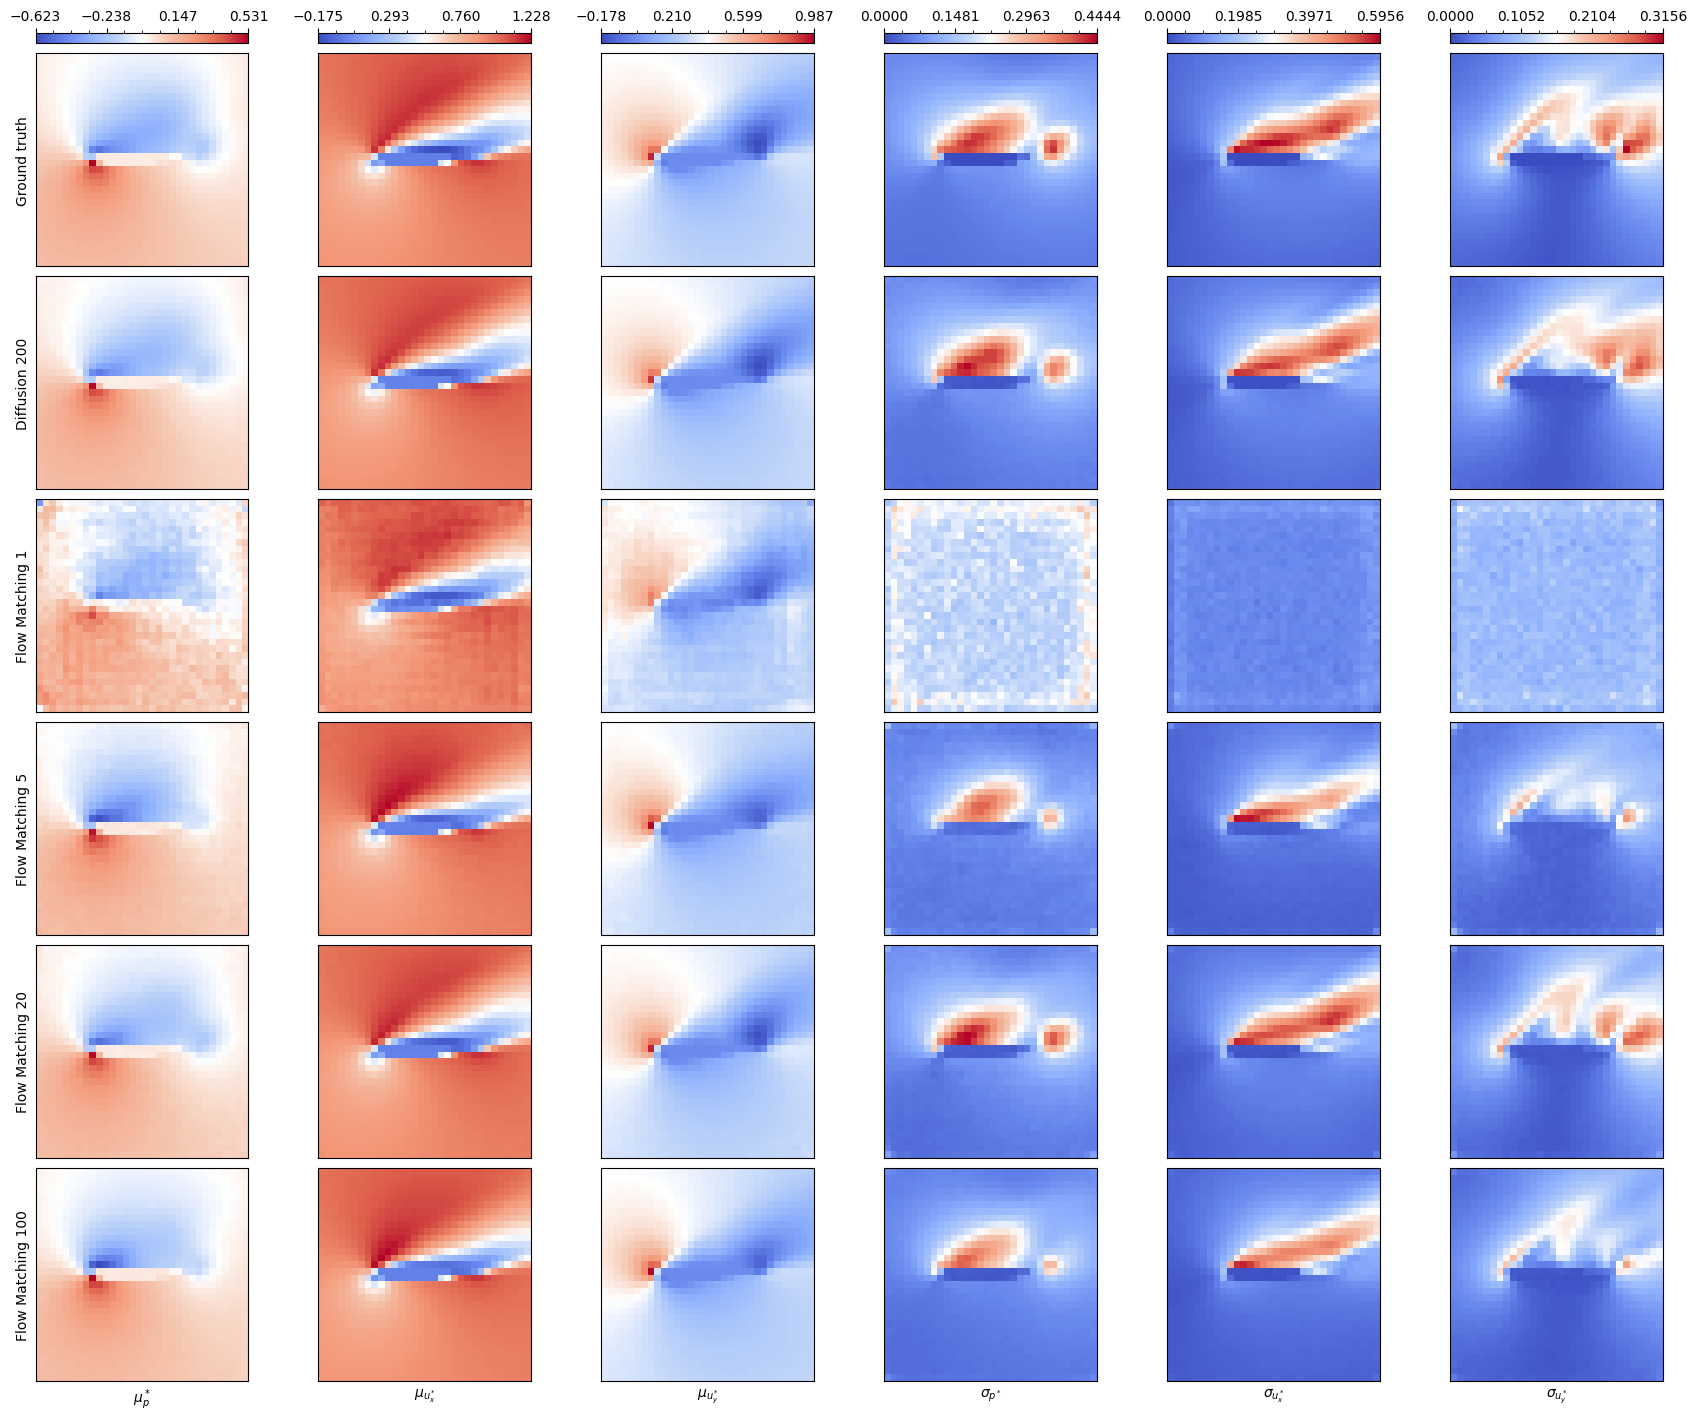

In [15]:
result_ground_truth=np.concatenate([mean_field_test_gd[index],std_field_test_gd[index]],axis=0)

CHANNEL_NAME_MEAN=[r"$\mu_p^*$",r"$\mu_{u_x^*}$",r"$\mu_{u_y^*}$"]
CHANNEL_NAME_STD=[r"$\sigma_{p^*}$",r"$\sigma_{u_x^*}$",r"$\sigma_{u_y^*}$"]

from airfoil_diffusion.plotter import *
show_each_channel([result_ground_truth,result_diffusion]+result_fms,
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=["Ground truth","Diffusion 200"]+titles,transpose=True,inverse_y=True)

The code above produced 100 samples with each method, and the image of the previous cell shows the mean and standard deviation for each spatial point in the regular grid. This illustrates that the mean is relatively easy to get right for all methods. The corresponding fields don't vary too much, and even the 1-step FM variant gets this mostly right (with a bit of noise). 

The standard deviation across the samples is more difficult: 1-step FM completely fails here, but, e.g., the 20-step FM version already does very well. This version only uses one tenth of steps compared to the DDPM version. The latter uses 200 steps, so the FM version is effectively 10x faster, while yielding a comparable accuracy here.



## Quantified Results

So far, we've focused on a single test case, and this could have been a "lucky" one for FM. Hence, below we'll repeat the evaluation for different cases across different Reynolds numbers to obtain quantified results. In total, the test set has six different Reynolds numbers, the middle four being interpolations of the training parameters, the first and last being extrapolations.

The `do_test()` helper function defined in the next cell directly computes the statistics for a given network over the whole test set.


In [16]:
def do_test(sample_func):
    mean_predictions=[]
    std_predictions=[]
    std_a_predictions=[]
    for input_field in tqdm(inputs_test):
        mean_fields,std_fields,_=sample_func(input_field.unsqueeze(0))
        mean_predictions.append(mean_fields)
        std_predictions.append(std_fields)
        std_a_predictions.append(np.mean(std_fields))
    return mean_predictions,std_predictions,std_a_predictions


Because of the larger number of test cases, the following cells can take a bit longer, especially for the diffusion model with its 200 steps.


In [17]:
std_a_fms=[]
labels=[]
for step in [1,5,20,100]:
    _,_,std_a_fm_i = do_test(lambda x:sample_flowmatching( network, x, dt=1/step, num_sample=500))
    std_a_fms.append(std_a_fm_i)
    labels.append("Flow Matching {}".format(step))


100%|██████████| 6/6 [02:09<00:00, 21.59s/it]


In [20]:
_,_,std_a_predictions_dif = do_test(lambda x:sample_diffusion(diffusion_trainer.diffuser, dif_network, x, num_diffusion_sample=500))

100%|██████████| 6/6 [03:40<00:00, 36.68s/it]


Now we have all the numbers, and the next cell produces a graph plotting the ground truth standard deviation per Re (blue line) next to the esimates from the different trained NNs.


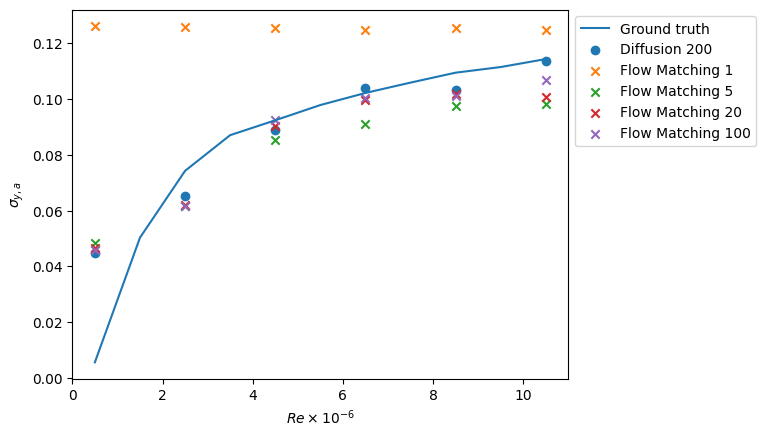

In [21]:
x=[0.5 +2*i for i in range(6)]
plt.plot([0.5 +i for i in range(11)],std_value_gd,label="Ground truth")
plt.scatter(x,std_a_predictions_dif,label="Diffusion 200",marker="o")
for i in range(len(std_a_fms)):
    plt.scatter(x,std_a_fms[i],label=labels[i],marker="x")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel(r"$Re \times 10^{-6}$")
plt.ylabel(r"$\sigma_{y,a}$")
plt.show()

The graph shows that the single result visualized above was not an outlier: 1-step FM doesn't do well, but 5- or 20-step FM are already very good, and largely on-par with the DDPM variant. In general, the accuracy of the NNs is very good. Even the last and first dots, the extrapolation regions, are captured reasonably well. The networks over-estimate the variance for the low Re cases because they haven't really seen static cases in training data, but the potentially more difficult high-Re case on the right is handled very well.

Overall, this setup is a non-trivial case: the networks had to learn the posterior distributions from almost constant to strongly varying across the differen Reynolds numbers. The _flow matching_ NNs really excel here: they yield excellent estimates and posterior samples with a very small number of integration steps. This is important for practical applications: these surrogate models have to compete with classical numerical simulations, and many fields have highly optimized simulation codes. Hence, it's important the trained NNs provide estimates quickly, with reasonable hardware requirements (i.e. not overly large parameter counts). These results indicate that _flow matching_ is a highly interesting contender for probabilistic simulations. 


## Next steps
- For this setup it is interesting to try higher order integration methods. Can you observe any gains over Euler? (Make sure to count all NFEs within the integrator, e.g., the four NN calls of the RK4 method.) 
- Improve the overall accuracy of the trained models by increasing the number of epochs, and the feature count of the U-net architecture.
- The implementation above uses _basic_ denoising and flow matching. It's worth trying improvements, e.g., additional rectification steps from the paper by Liu et al. This could potentially reduce the number of required steps even further.
